In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import random                             # randon numbers
from scipy.stats import norm              # Gaussian parametric distribution
import geostatspy.GSLIB as GSLIB
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                    

# tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
import pandas.plotting as pd_plot
from intake import cat                                    # data catalogue
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tqdm.notebook import trange, tqdm



well_df = pd.read_csv('wellData.csv')
day_df = pd.read_csv('dailyData.csv')
solution_df = pd.read_csv("solution.csv")

well_df = well_df.drop(['ESP_Motor_Frequency_Rating', 'Unnamed: 0', 'Artificial_Lift_Type'], axis =1)
well_df

,Well_ID,AL_Key,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth
0,345,ESP_2,9056.67,0,5.323174,NaN,NaN,NaN,1.713554
1,29,ESP_3,8982.09,0,6.440650,NaN,NaN,NaN,2.789395
2,327,ESP_1,8876.37,0,5.669751,NaN,NaN,NaN,0.481680
3,71,ESP_1,8930.11,0,5.614798,NaN,NaN,NaN,0.842038
4,125,ESP_2,8616.41,348,26.061750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
161,341,ESP_1,7927.90,504,17.561921,NaN,NaN,NaN,NaN
162,143,ESP_1,8041.24,0,12.231519,NaN,NaN,NaN,NaN
163,258,ESP_1,7908.00,445,12.905506,NaN,NaN,NaN,9.620484
164,285,ESP_1,7958.81,415,12.924289,NaN,NaN,NaN,10.935088


In [2]:
day_df = day_df.drop('ARTIFICIAL_LIFT', axis =1)
"""
day_df = day_df.drop(['Lower_Limit', 'Power_Difference', 'ESP Data - Motor Winding Temperature', 'Drive_Power','ESP Data - Output Frequency',
'Gas_through_Annulus_Intake','ESP Data - Drive Voltage','Discharge_Pressure','ESP Data - Motor Temperature Shutdown Setpoint',
'Gas_Saturation_at_Discharge','Pump_Average_Pressure','Pump_Power','ARTIFICIAL_LIFT',
'Power_Ratio','ESP Data - Drive Current','ESP Data - Vibration X','Startup_Count','Gas_through_Annulus','ESP_Fluid','Pb_ESP'], axis = 1)
day_df
"""

"\nday_df = day_df.drop(['Lower_Limit', 'Power_Difference', 'ESP Data - Motor Winding Temperature', 'Drive_Power','ESP Data - Output Frequency',\n'Gas_through_Annulus_Intake','ESP Data - Drive Voltage','Discharge_Pressure','ESP Data - Motor Temperature Shutdown Setpoint',\n'Gas_Saturation_at_Discharge','Pump_Average_Pressure','Pump_Power','ARTIFICIAL_LIFT',\n'Power_Ratio','ESP Data - Drive Current','ESP Data - Vibration X','Startup_Count','Gas_through_Annulus','ESP_Fluid','Pb_ESP'], axis = 1)\nday_df\n"

In [3]:
new_df_2 = well_df.drop(['AL_Key'], axis = 1).copy()

imputer_2 = IterativeImputer(tol = 1e-2)
imputer_2.fit(new_df_2)
imputed_array_2 = imputer_2.transform(new_df_2)

imputed2_df = pd.DataFrame(imputed_array_2)
imputed2_df

,0,1,2,3,4,5,6,7
0,345.0,9056.67,0.0,5.323174,56.046929,3409.779481,309.252209,1.713554
1,29.0,8982.09,0.0,6.440650,54.279085,3739.342582,335.712037,2.789395
2,327.0,8876.37,0.0,5.669751,58.025138,3385.829184,307.680447,0.481680
3,71.0,8930.11,0.0,5.614798,55.299631,3679.213287,330.892139,0.842038
4,125.0,8616.41,348.0,26.061750,64.887168,2297.913622,233.736284,4.789396
...,...,...,...,...,...,...,...,...
161,341.0,7927.90,504.0,17.561921,78.077368,1324.215271,160.627653,5.899696
162,143.0,8041.24,0.0,12.231519,66.005019,3394.013203,310.617004,4.213202
163,258.0,7908.00,445.0,12.905506,76.710015,1623.538707,182.290634,9.620484
164,285.0,7958.81,415.0,12.924289,75.754476,1715.839933,188.750968,10.935088


In [4]:
names_well = new_df_2.columns

i = 0
static_df = imputed2_df.rename({i : names_well[i] for i in range(len(names_well))}, axis = 'columns')
    
static_df["AL_Key"] = well_df.loc[:,"AL_Key"]
static_df

,Well_ID,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,AL_Key
0,345.0,9056.67,0.0,5.323174,56.046929,3409.779481,309.252209,1.713554,ESP_2
1,29.0,8982.09,0.0,6.440650,54.279085,3739.342582,335.712037,2.789395,ESP_3
2,327.0,8876.37,0.0,5.669751,58.025138,3385.829184,307.680447,0.481680,ESP_1
3,71.0,8930.11,0.0,5.614798,55.299631,3679.213287,330.892139,0.842038,ESP_1
4,125.0,8616.41,348.0,26.061750,64.887168,2297.913622,233.736284,4.789396,ESP_2
...,...,...,...,...,...,...,...,...,...
161,341.0,7927.90,504.0,17.561921,78.077368,1324.215271,160.627653,5.899696,ESP_1
162,143.0,8041.24,0.0,12.231519,66.005019,3394.013203,310.617004,4.213202,ESP_1
163,258.0,7908.00,445.0,12.905506,76.710015,1623.538707,182.290634,9.620484,ESP_1
164,285.0,7958.81,415.0,12.924289,75.754476,1715.839933,188.750968,10.935088,ESP_1


In [5]:
new_df = day_df.drop(['AL_Key'], axis = 1).copy()

imputer = IterativeImputer(tol = 5e-2)
imputer.fit(new_df)
imputed_array = imputer.transform(new_df)

imputed_df = pd.DataFrame(imputed_array)
imputed_df

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,615.154601,650.447788,526.488655,11.0,249.860279,370.149250,368.715449,-509.534789,187.439259,57.443323,...,3.314110e+14,1154.825236,-1.623917e+14,-1.461464e+14,96.303097,-3.842932e+13,1.541419e+14,5.379407e+15,1148.388862,345.0
1,1224.193640,1232.455787,809.414685,0.0,135.239185,464.211750,-261.284551,-2445.534789,188.548634,60.605921,...,3.204875e+14,1406.825236,-1.570392e+14,-1.413294e+14,92.427609,-3.716267e+13,1.490613e+14,5.202099e+15,1208.795112,345.0
2,1007.769762,1047.068544,667.933899,0.0,146.440357,424.086750,-200.909551,-1629.534789,190.544728,60.009729,...,4.747602e+14,1200.106486,-2.326330e+14,-2.093609e+14,88.067746,-5.505163e+13,2.208148e+14,7.706228e+15,1284.802925,345.0
3,1514.641876,1370.143160,1122.137652,0.0,207.901295,505.961750,222.215449,-2717.534789,179.779103,59.466028,...,-2.539874e+14,2033.418986,1.244541e+14,1.120040e+14,116.018918,2.945154e+13,-1.181316e+14,-4.122681e+15,1255.006050,345.0
4,1089.741764,1387.138130,1156.169599,0.0,153.452076,487.446125,303.371699,-2293.534789,186.111134,58.695276,...,9.932682e+13,1976.973674,-4.867024e+13,-4.380139e+13,98.926816,-1.151761e+13,4.619770e+13,1.612256e+15,1128.841987,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50051,130.568357,335.639084,433.161488,0.0,232.000000,433.000000,894.599976,240.000000,182.800003,55.000000,...,1.703463e+03,1746.331510,1.681018e-01,1.872407e+01,100.456000,2.071009e-01,8.173193e+01,1.686796e+02,600.000000,142.0
50052,135.061535,338.161005,421.979434,0.0,232.000000,433.000000,894.599976,240.000000,182.800003,55.000000,...,1.668437e+03,1728.818696,1.719572e-01,1.826407e+01,100.456000,2.020129e-01,8.219193e+01,1.687669e+02,600.000000,142.0
50053,135.757477,341.732930,428.363835,0.0,230.433113,431.364779,893.432975,240.000000,182.836947,55.000000,...,1.663311e+03,1725.088591,1.732141e-01,1.845284e+01,99.400729,2.062677e-01,8.094789e+01,1.686728e+02,600.000000,142.0
50054,64.788755,170.379740,221.002588,12.0,243.458937,423.202102,934.540501,240.000000,186.748578,54.836954,...,1.604082e+03,1736.581602,1.627178e-01,8.862240e+00,103.032334,9.557130e-02,9.417009e+01,1.727154e+02,600.000000,142.0


In [6]:
names = new_df.columns

i = 0
dynamic_df = imputed_df.rename({i : names[i] for i in range(len(names))}, axis = 'columns')
    
dynamic_df["AL_Key"] = day_df.loc[:,"AL_Key"]
dynamic_df

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,...,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,Well_ID,AL_Key
0,615.154601,650.447788,526.488655,11.0,249.860279,370.149250,368.715449,-509.534789,187.439259,57.443323,...,1154.825236,-1.623917e+14,-1.461464e+14,96.303097,-3.842932e+13,1.541419e+14,5.379407e+15,1148.388862,345.0,ESP_2
1,1224.193640,1232.455787,809.414685,0.0,135.239185,464.211750,-261.284551,-2445.534789,188.548634,60.605921,...,1406.825236,-1.570392e+14,-1.413294e+14,92.427609,-3.716267e+13,1.490613e+14,5.202099e+15,1208.795112,345.0,ESP_2
2,1007.769762,1047.068544,667.933899,0.0,146.440357,424.086750,-200.909551,-1629.534789,190.544728,60.009729,...,1200.106486,-2.326330e+14,-2.093609e+14,88.067746,-5.505163e+13,2.208148e+14,7.706228e+15,1284.802925,345.0,ESP_2
3,1514.641876,1370.143160,1122.137652,0.0,207.901295,505.961750,222.215449,-2717.534789,179.779103,59.466028,...,2033.418986,1.244541e+14,1.120040e+14,116.018918,2.945154e+13,-1.181316e+14,-4.122681e+15,1255.006050,345.0,ESP_2
4,1089.741764,1387.138130,1156.169599,0.0,153.452076,487.446125,303.371699,-2293.534789,186.111134,58.695276,...,1976.973674,-4.867024e+13,-4.380139e+13,98.926816,-1.151761e+13,4.619770e+13,1.612256e+15,1128.841987,345.0,ESP_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50051,130.568357,335.639084,433.161488,0.0,232.000000,433.000000,894.599976,240.000000,182.800003,55.000000,...,1746.331510,1.681018e-01,1.872407e+01,100.456000,2.071009e-01,8.173193e+01,1.686796e+02,600.000000,142.0,ESP_1
50052,135.061535,338.161005,421.979434,0.0,232.000000,433.000000,894.599976,240.000000,182.800003,55.000000,...,1728.818696,1.719572e-01,1.826407e+01,100.456000,2.020129e-01,8.219193e+01,1.687669e+02,600.000000,142.0,ESP_1
50053,135.757477,341.732930,428.363835,0.0,230.433113,431.364779,893.432975,240.000000,182.836947,55.000000,...,1725.088591,1.732141e-01,1.845284e+01,99.400729,2.062677e-01,8.094789e+01,1.686728e+02,600.000000,142.0,ESP_1
50054,64.788755,170.379740,221.002588,12.0,243.458937,423.202102,934.540501,240.000000,186.748578,54.836954,...,1736.581602,1.627178e-01,8.862240e+00,103.032334,9.557130e-02,9.417009e+01,1.727154e+02,600.000000,142.0,ESP_1


In [7]:
index_day_df = dynamic_df.set_index(["Well_ID", "AL_Key"])
index_day_df

OIL          GAS        WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                           
345.0   ESP_2    615.154601   650.447788   526.488655             11.0   
        ESP_2   1224.193640  1232.455787   809.414685              0.0   
        ESP_2   1007.769762  1047.068544   667.933899              0.0   
        ESP_2   1514.641876  1370.143160  1122.137652              0.0   
        ESP_2   1089.741764  1387.138130  1156.169599              0.0   
...                     ...          ...          ...              ...   
142.0   ESP_1    130.568357   335.639084   433.161488              0.0   
        ESP_1    135.061535   338.161005   421.979434              0.0   
        ESP_1    135.757477   341.732930   428.363835              0.0   
        ESP_1     64.788755   170.379740   221.002588             12.0   
        ESP_1      0.000000     0.000000     0.000000             24.0   

                ESP Data - Drive Current  ESP Data - Drive Voltage  \
Well_ID AL_Key                                                       
345.0   ESP_2                 249.860279                370.149250   
        ESP_2                 135.239185                464.211750   
        ESP_2                 146.440357                424.086750   
        ESP_2                 207.901295                505.961750   
        ESP_2                 153.452076                487.446125   
...                                  ...                       ...   
142.0   ESP_1                 232.000000                433.000000   
        ESP_1                 232.000000                433.000000   
        ESP_1                 230.433113                431.364779   
        ESP_1                 243.458937                423.202102   
        ESP_1                 369.099649                402.275272   

                ESP Data - Intake Pressure  \
Well_ID AL_Key                               
345.0   ESP_2                   368.715449   
        ESP_2                  -261.284551   
        ESP_2                  -200.909551   
        ESP_2                   222.215449   
        ESP_2                   303.371699   
...                                    ...   
142.0   ESP_1                   894.599976   
        ESP_1                   894.599976   
        ESP_1                   893.432975   
        ESP_1                   934.540501   
        ESP_1                  1527.854901   

                ESP Data - Motor Temperature Shutdown Setpoint  \
Well_ID AL_Key                                                   
345.0   ESP_2                                      -509.534789   
        ESP_2                                     -2445.534789   
        ESP_2                                     -1629.534789   
        ESP_2                                     -2717.534789   
        ESP_2                                     -2293.534789   
...                                                        ...   
142.0   ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   

                ESP Data - Motor Winding Temperature  \
Well_ID AL_Key                                         
345.0   ESP_2                             187.439259   
        ESP_2                             188.548634   
        ESP_2                             190.544728   
        ESP_2                             179.779103   
        ESP_2                             186.111134   
...                                              ...   
142.0   ESP_1                             182.800003   
        ESP_1                             182.800003   
        ESP_1                             182.836947   
        ESP_1                             186.748578   
        ESP_1       

In [8]:
total_days = dynamic_df.groupby(["Well_ID", "AL_Key"], sort = False, as_index = False)["OIL"].count()

static_df["Days_ToDeath"] = total_days.loc[:,"OIL"]
static_df

,Well_ID,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,AL_Key,Days_ToDeath
0,345.0,9056.67,0.0,5.323174,56.046929,3409.779481,309.252209,1.713554,ESP_2,431.0
1,29.0,8982.09,0.0,6.440650,54.279085,3739.342582,335.712037,2.789395,ESP_3,407.0
2,327.0,8876.37,0.0,5.669751,58.025138,3385.829184,307.680447,0.481680,ESP_1,356.0
3,71.0,8930.11,0.0,5.614798,55.299631,3679.213287,330.892139,0.842038,ESP_1,367.0
4,125.0,8616.41,348.0,26.061750,64.887168,2297.913622,233.736284,4.789396,ESP_2,128.0
...,...,...,...,...,...,...,...,...,...,...
161,341.0,7927.90,504.0,17.561921,78.077368,1324.215271,160.627653,5.899696,ESP_1,37.0
162,143.0,8041.24,0.0,12.231519,66.005019,3394.013203,310.617004,4.213202,ESP_1,262.0
163,258.0,7908.00,445.0,12.905506,76.710015,1623.538707,182.290634,9.620484,ESP_1,398.0
164,285.0,7958.81,415.0,12.924289,75.754476,1715.839933,188.750968,10.935088,ESP_1,428.0


In [9]:
L60_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    L60_daily_df.append(sub_df.tail(60))
    
L60_daily_df = pd.concat(L60_daily_df)
L60_daily_df

  0%|          | 0/165 [00:00<?, ?it/s]

/tmp/ipykernel_14793/2758770964.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = index_day_df.loc[_iter]


OIL         GAS       WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                        
345.0   ESP_2   288.280109  577.874234  285.779169              6.0   
        ESP_2   348.151863  702.095092  352.320096              3.0   
        ESP_2   205.246123  474.816577  229.794533             10.0   
        ESP_2   288.351195  572.334901  300.289356              6.0   
        ESP_2   340.058815  659.323860  318.221371              4.0   
...                    ...         ...         ...              ...   
142.0   ESP_1   130.568357  335.639084  433.161488              0.0   
        ESP_1   135.061535  338.161005  421.979434              0.0   
        ESP_1   135.757477  341.732930  428.363835              0.0   
        ESP_1    64.788755  170.379740  221.002588             12.0   
        ESP_1     0.000000    0.000000    0.000000             24.0   

                ESP Data - Drive Current  ESP Data - Drive Voltage  \
Well_ID AL_Key                                                       
345.0   ESP_2                 215.109996                397.465961   
        ESP_2                 198.041231                398.821667   
        ESP_2                 194.706247                400.003670   
        ESP_2                 190.186667                391.473530   
        ESP_2                 202.353641                381.488755   
...                                  ...                       ...   
142.0   ESP_1                 232.000000                433.000000   
        ESP_1                 232.000000                433.000000   
        ESP_1                 230.433113                431.364779   
        ESP_1                 243.458937                423.202102   
        ESP_1                 369.099649                402.275272   

                ESP Data - Intake Pressure  \
Well_ID AL_Key                               
345.0   ESP_2                   822.468938   
        ESP_2                   840.591594   
        ESP_2                   831.423514   
        ESP_2                   832.989565   
        ESP_2                   845.083539   
...                                    ...   
142.0   ESP_1                   894.599976   
        ESP_1                   894.599976   
        ESP_1                   893.432975   
        ESP_1                   934.540501   
        ESP_1                  1527.854901   

                ESP Data - Motor Temperature Shutdown Setpoint  \
Well_ID AL_Key                                                   
345.0   ESP_2                                      -661.948796   
        ESP_2                                      -624.821807   
        ESP_2                                      -691.838919   
        ESP_2                                      -468.889981   
        ESP_2                                      -564.632459   
...                                                        ...   
142.0   ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   

                ESP Data - Motor Winding Temperature  \
Well_ID AL_Key                                         
345.0   ESP_2                             188.956811   
        ESP_2                             187.808472   
        ESP_2                             187.275934   
        ESP_2                             186.506637   
        ESP_2                             187.187105   
...                                              ...   
142.0   ESP_1                             182.800003   
        ESP_1                             182.800003   
        ESP_1                             182.836947   
        ESP_1                             186.748578   
        ESP_1                             224.843614   

 

In [10]:
B30_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    B30_daily_df.append(sub_df.head(30))
    
B30_daily_df = pd.concat(B30_daily_df)

B30_daily_df.insert(35, "Will_Fail", 0)
B30_daily_df

  0%|          | 0/165 [00:00<?, ?it/s]

/tmp/ipykernel_14793/1526557124.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = index_day_df.loc[_iter]


OIL          GAS        WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                           
345.0   ESP_2    615.154601   650.447788   526.488655             11.0   
        ESP_2   1224.193640  1232.455787   809.414685              0.0   
        ESP_2   1007.769762  1047.068544   667.933899              0.0   
        ESP_2   1514.641876  1370.143160  1122.137652              0.0   
        ESP_2   1089.741764  1387.138130  1156.169599              0.0   
...                     ...          ...          ...              ...   
142.0   ESP_1    476.440404   475.636590  1617.746737              0.0   
        ESP_1    493.195216   477.489537  1668.867183              0.0   
        ESP_1    483.943532   479.166758  1619.862401              0.0   
        ESP_1    502.700049   482.770869  1586.592877              0.0   
        ESP_1    504.609541   504.976651  1517.329213              0.0   

                ESP Data - Drive Current  ESP Data - Drive Voltage  \
Well_ID AL_Key                                                       
345.0   ESP_2                 249.860279                370.149250   
        ESP_2                 135.239185                464.211750   
        ESP_2                 146.440357                424.086750   
        ESP_2                 207.901295                505.961750   
        ESP_2                 153.452076                487.446125   
...                                  ...                       ...   
142.0   ESP_1                 274.733507                365.000000   
        ESP_1                 274.197963                365.000000   
        ESP_1                 274.016701                365.000000   
        ESP_1                 274.067373                365.000000   
        ESP_1                 273.773796                365.000000   

                ESP Data - Intake Pressure  \
Well_ID AL_Key                               
345.0   ESP_2                   368.715449   
        ESP_2                  -261.284551   
        ESP_2                  -200.909551   
        ESP_2                   222.215449   
        ESP_2                   303.371699   
...                                    ...   
142.0   ESP_1                  2784.520055   
        ESP_1                  2763.703420   
        ESP_1                  2743.241810   
        ESP_1                  2725.349775   
        ESP_1                  2708.283400   

                ESP Data - Motor Temperature Shutdown Setpoint  \
Well_ID AL_Key                                                   
345.0   ESP_2                                      -509.534789   
        ESP_2                                     -2445.534789   
        ESP_2                                     -1629.534789   
        ESP_2                                     -2717.534789   
        ESP_2                                     -2293.534789   
...                                                        ...   
142.0   ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   

                ESP Data - Motor Winding Temperature  \
Well_ID AL_Key                                         
345.0   ESP_2                             187.439259   
        ESP_2                             188.548634   
        ESP_2                             190.544728   
        ESP_2                             179.779103   
        ESP_2                             186.111134   
...                                              ...   
142.0   ESP_1                             174.226754   
        ESP_1                             174.280443   
        ESP_1                             174.302246   
        ESP_1                             174.307828   
        ESP_1       

In [11]:
final_data = pd.concat([B30_daily_df, L60_daily_df],
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=False,)

final_data = final_data.fillna(1)
final_data["Will_Fail"] = final_data["Will_Fail"].apply(np.int64)
final_data

OIL          GAS        WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                           
345.0   ESP_2    615.154601   650.447788   526.488655             11.0   
        ESP_2   1224.193640  1232.455787   809.414685              0.0   
        ESP_2   1007.769762  1047.068544   667.933899              0.0   
        ESP_2   1514.641876  1370.143160  1122.137652              0.0   
        ESP_2   1089.741764  1387.138130  1156.169599              0.0   
...                     ...          ...          ...              ...   
142.0   ESP_1    130.568357   335.639084   433.161488              0.0   
        ESP_1    135.061535   338.161005   421.979434              0.0   
        ESP_1    135.757477   341.732930   428.363835              0.0   
        ESP_1     64.788755   170.379740   221.002588             12.0   
        ESP_1      0.000000     0.000000     0.000000             24.0   

                ESP Data - Drive Current  ESP Data - Drive Voltage  \
Well_ID AL_Key                                                       
345.0   ESP_2                 249.860279                370.149250   
        ESP_2                 135.239185                464.211750   
        ESP_2                 146.440357                424.086750   
        ESP_2                 207.901295                505.961750   
        ESP_2                 153.452076                487.446125   
...                                  ...                       ...   
142.0   ESP_1                 232.000000                433.000000   
        ESP_1                 232.000000                433.000000   
        ESP_1                 230.433113                431.364779   
        ESP_1                 243.458937                423.202102   
        ESP_1                 369.099649                402.275272   

                ESP Data - Intake Pressure  \
Well_ID AL_Key                               
345.0   ESP_2                   368.715449   
        ESP_2                  -261.284551   
        ESP_2                  -200.909551   
        ESP_2                   222.215449   
        ESP_2                   303.371699   
...                                    ...   
142.0   ESP_1                   894.599976   
        ESP_1                   894.599976   
        ESP_1                   893.432975   
        ESP_1                   934.540501   
        ESP_1                  1527.854901   

                ESP Data - Motor Temperature Shutdown Setpoint  \
Well_ID AL_Key                                                   
345.0   ESP_2                                      -509.534789   
        ESP_2                                     -2445.534789   
        ESP_2                                     -1629.534789   
        ESP_2                                     -2717.534789   
        ESP_2                                     -2293.534789   
...                                                        ...   
142.0   ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   
        ESP_1                                       240.000000   

                ESP Data - Motor Winding Temperature  \
Well_ID AL_Key                                         
345.0   ESP_2                             187.439259   
        ESP_2                             188.548634   
        ESP_2                             190.544728   
        ESP_2                             179.779103   
        ESP_2                             186.111134   
...                                              ...   
142.0   ESP_1                             182.800003   
        ESP_1                             182.800003   
        ESP_1                             182.836947   
        ESP_1                             186.748578   
        ESP_1       

In [12]:
corr_matrix = final_data.corr()
corr_matrix

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,...,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,Will_Fail
OIL,1.000000,0.674166,0.633723,-0.126785,0.362243,0.084047,0.450072,0.098880,-0.143684,-0.344489,...,-0.256394,0.471382,0.256394,0.256394,0.453148,0.256394,-0.256394,-0.256394,0.213602,-0.527994
GAS,0.674166,1.000000,0.418087,-0.079346,0.177509,0.227927,0.260423,-0.054213,-0.127719,-0.090326,...,-0.161675,0.310060,0.161675,0.161675,0.299198,0.161675,-0.161675,-0.161675,0.172486,-0.307111
WATER,0.633723,0.418087,1.000000,-0.314159,0.564185,-0.005359,0.698416,0.101443,-0.201683,-0.527899,...,-0.418865,0.738371,0.418865,0.418865,0.587492,0.418865,-0.418865,-0.418865,0.160140,-0.623805
DOWN_TIME_HOURS,-0.126785,-0.079346,-0.314159,1.000000,-0.007932,-0.068210,-0.039770,-0.083384,0.029960,0.001105,...,0.058846,-0.087783,-0.058846,-0.058846,-0.047515,-0.058846,0.058846,0.058846,-0.002464,0.026982
ESP Data - Drive Current,0.362243,0.177509,0.564185,-0.007932,1.000000,0.189873,0.732646,-0.028883,-0.553822,-0.401921,...,-0.737936,0.701474,0.737936,0.737936,0.929220,0.737936,-0.737936,-0.737936,-0.003967,-0.359979
ESP Data - Drive Voltage,0.084047,0.227927,-0.005359,-0.068210,0.189873,1.000000,-0.054255,-0.093769,-0.153351,0.359688,...,-0.293556,0.081300,0.293556,0.293556,0.330513,0.293556,-0.293556,-0.293556,0.010844,0.087266
ESP Data - Intake Pressure,0.450072,0.260423,0.698416,-0.039770,0.732646,-0.054255,1.000000,0.022324,-0.472623,-0.680581,...,-0.734514,0.892092,0.734514,0.734514,0.638652,0.734514,-0.734514,-0.734514,0.101833,-0.554366
ESP Data - Motor Temperature Shutdown Setpoint,0.098880,-0.054213,0.101443,-0.083384,-0.028883,-0.093769,0.022324,1.000000,0.130364,-0.067623,...,0.039439,-0.012787,-0.039439,-0.039439,-0.021618,-0.039439,0.039439,0.039439,0.089185,-0.050350
ESP Data - Motor Winding Temperature,-0.143684,-0.127719,-0.201683,0.029960,-0.553822,-0.153351,-0.472623,0.130364,1.000000,0.396066,...,0.683955,-0.475524,-0.683955,-0.683955,-0.415840,-0.683955,0.683955,0.683955,0.089677,0.169230
ESP Data - Output Frequency,-0.344489,-0.090326,-0.527899,0.001105,-0.401921,0.359688,-0.680581,-0.067623,0.396066,1.000000,...,0.391405,-0.617155,-0.391405,-0.391405,-0.218832,-0.391405,0.391405,0.391405,-0.126861,0.521499


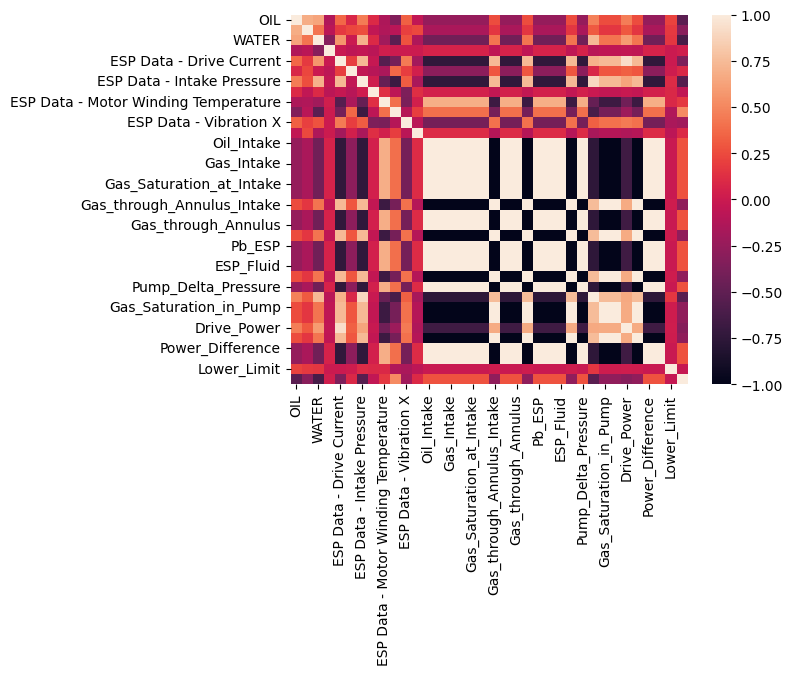

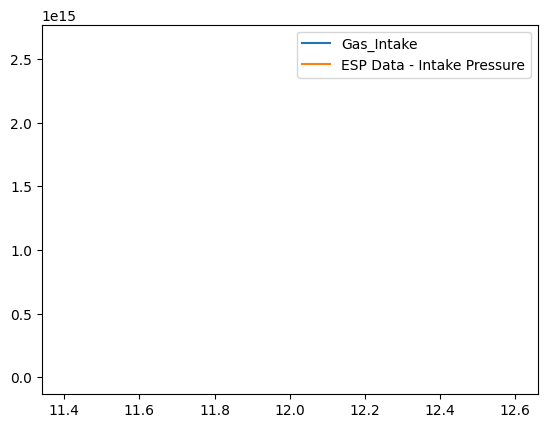

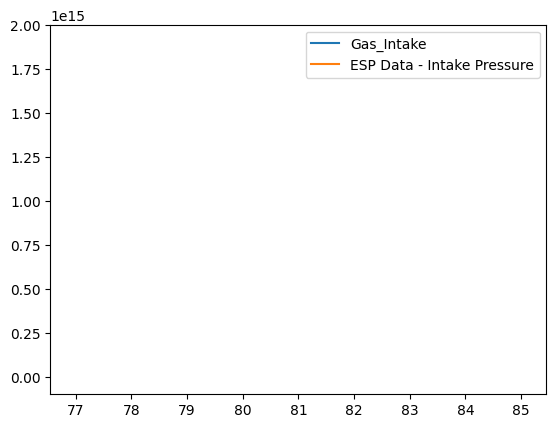

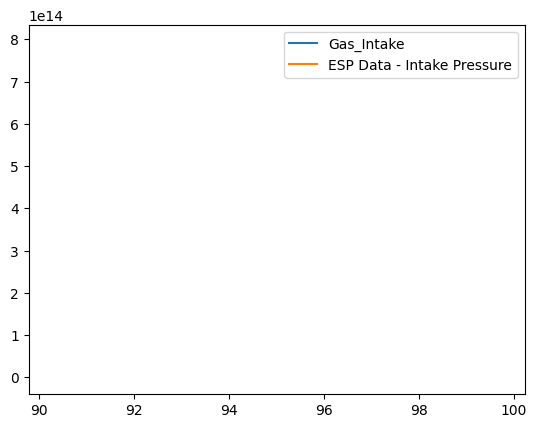

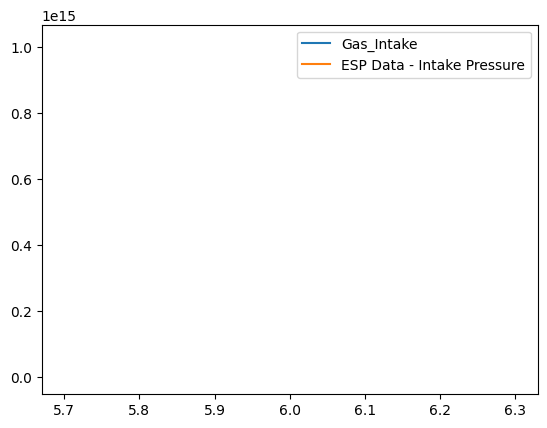

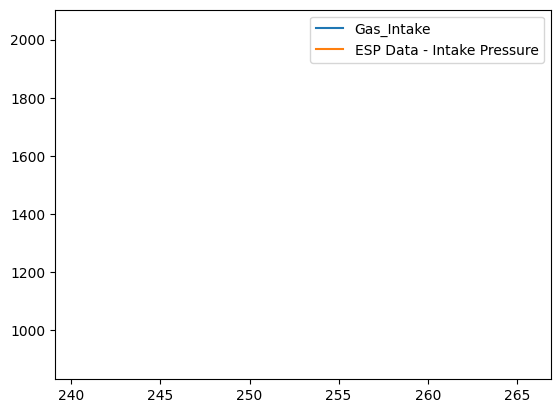

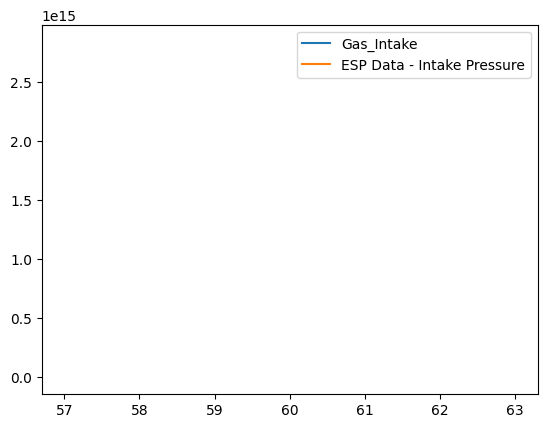

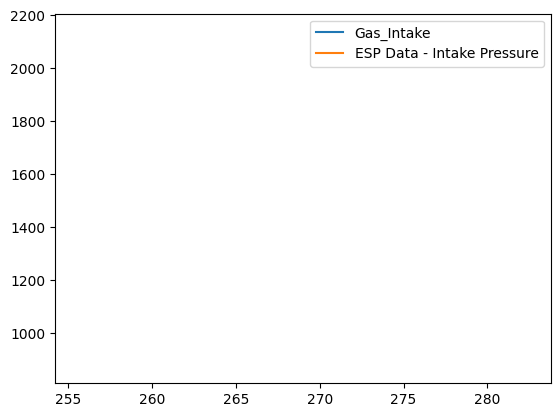

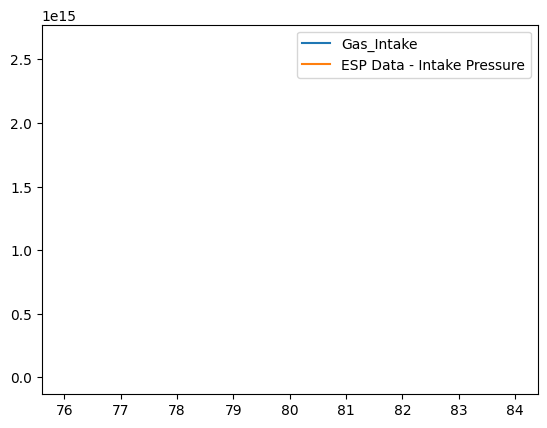

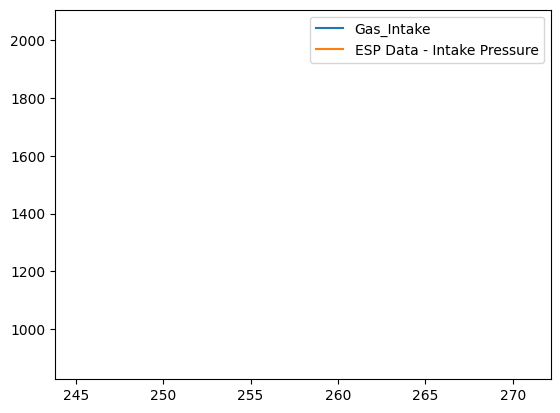

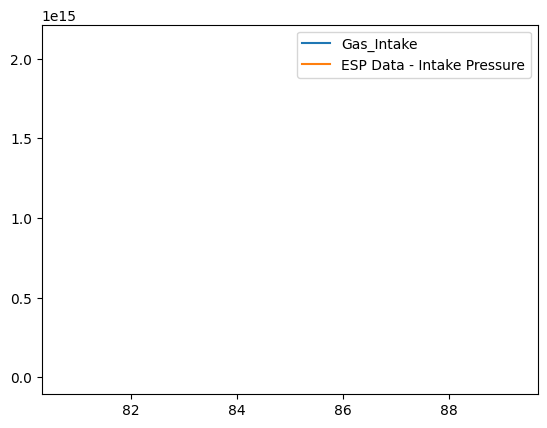

In [13]:

sn.heatmap(corr_matrix, annot=False)
columns =  [ 'Gas_Intake', 'ESP Data - Intake Pressure']
import random
for i in range(10):
    
    well_ids = dynamic_df['Well_ID']
    id_ = random.choice(well_ids)
    df_filtered = dynamic_df[dynamic_df.index == id_]
    df_filtered[columns].plot()

plt.show()


In [ ]:
pd_plot.scatter_matrix(final_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

In [ ]:
X = final_data.loc[:, final_data.columns != 'Will_Fail']
y = final_data.loc[:, final_data.columns == 'Will_Fail']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns

os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Will_Fail'])



In [ ]:
final_data_vars = final_data.columns.values.tolist()

X=[i for i in final_data_vars if i not in y]



from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
final_cols = []
for col, flag in zip(list(final_data.columns), rfe.support_):
    if flag:
        final_cols.append(col)
final_cols

In [ ]:
# Select 2 predictor features here:
predictor_features = final_data[final_cols]           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Will_Fail'

X = predictor_features                # extract the 2 selected response features, 500 samples to a X array
y = final_data[response_feature]  

X_tmp = X.reset_index(drop=False)
X_tmp["PK"] = X_tmp["Well_ID"].astype(int).astype(str) + X_tmp["AL_Key"].astype(str)
solution_df["PK"] = solution_df["Well_ID"].astype(str) + solution_df["AL_Key"].astype(str)
mask = X_tmp["PK"].apply(lambda pk: pk in solution_df["PK"].unique())
X = X[~mask.to_numpy()]
y = y[~mask.to_numpy()]

solution_df.drop(columns=["PK"], inplace=True)
del X_tmp
X # extract selected response 500 samples to a response array

In [ ]:
assert X.shape[0] == y.shape[0]

In [ ]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

In [ ]:
# Decison Tree Model with scikit learn
from sklearn import tree                                     # for accessing tree information

# Step 1. Instantiate the Model 
decision_tree_reg = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_train = len(X_train)
n_test = len(X_test)

# Step 2: Fit the Data on Training Data
decision_tree_reg.fit(X_train, y_train) # fit model

# Step 3: - Make predictions using the testing dataset
tree_y_pred = decision_tree_reg.predict(X_test)

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, tree_y_pred))


In [ ]:
# import warnings
# warnins.ignore("
for series in solution_df.itertuples():
    index = series.Well_ID, series.AL_Key
    solution_df.loc[series.Index, "Fail in 30 days"] = np.round(decision_tree_reg.predict(predictor_features.loc[index]).mean(),0)

solution_df
solution_df.to_csv('solution.csv')
